# Paper reproduction: Communication-Efficient Distributed SGD using Preamble-based Random Access by Choi Available at https://arxiv.org/abs/2105.09427

## Imports and Definitions

In [51]:
# Import needed libraries
import numpy as np # arrays
import matplotlib.pyplot as plt #ploting
import scipy.optimize as sciopt    # linprog
from scipy.optimize import nnls # NNLS SOLVER

In [52]:
# Definitions
K = 100 # Number of datasets distributed over K devices (i.e., 1 data set per device)
L = 8 # Lenght of w
u =  0.01 # step size or learning rate
T = 1000 # Number of iterations

## Auxiliary functions

Construct the codebook as a scaled cross polytope:
$$ \cal{C}_{cp} = \{ \pm \textrm{R}e_l : \{1,...,\textrm{L}\}\} $$
with $ R = \sqrt{L} $.

In [53]:
def construct_codebook(L):
    # Construct the codebook as a scaled cross polytope
    R = np.sqrt(L)
    # R= 1 #testing
    codebook = np.concatenate(((np.eye(L)*R),(np.eye(L)*(-R))),axis=0)
    return codebook

## Class Device

In [54]:
class Device:
    def __init__(self,L, weights_optimal,codebook):
        
        self.weights = np.zeros(L) # Initialize device's weights to 0
        self.x = np.random.normal(size = (1,L)) # Initialize devices's data set
        self.y = self.x@weights_optimal # Initalize y used for the gradient
        self.g = np.zeros(L)
        self.codebook = codebook
        
    def setWeights(self,new_weights):
        self.weights = new_weights
        
    def gradient(self):
    
        # Calculating the Gradient:
        # 1. Compute predictions, given the feature matrix X of shape (m,n) and weight vector w of shape (n,1).
        #    Predictions should be stored in an array `y_hat` of shape (m,1).
        y_hat = self.x@self.weights
        # 2. compute MSE loss
        m = self.x.shape[0]
        MSE = (1/m)*np.sum((self.y-y_hat)**2)
        # 3. compute average gradient of loss function
        gradient = (-2/m)*self.x.T@(self.y-y_hat)

        self.g = gradient
        return gradient, MSE
    
    ### NNLS ###
    def quantize(self):
        codebook = self.codebook
        v_til = (self.g)/np.linalg.norm(self.g)
            
        # solving the linear system
        M = codebook.shape[0]
        c = np.ones((1,M))
        A = np.concatenate((codebook.T,np.ones((1,M))),axis=0)
        b = np.concatenate((v_til,np.ones(1)),axis=0)
        
        a_vec = nnls(A, b)[0] # Using Non-negative Least Squares
        ## scipy.optimize.nnls solves the KKT (Karush-Kuhn-Tucker) conditions for the non-negative least squares problem.
        
        c_idx = np.random.choice(M, p=a_vec) # use a_vec as probabilities for choosing the codeword
        a = a_vec[c_idx]
        return a,c_idx # returns the probability(why? maybe remove later) and the index of the codeword

## Class Base Station

In [55]:
class BaseStation:
    def __init__(self,L,codebook):
        
        self.weights = np.zeros(L)
        self.codebook = codebook
        
    def setWeights(self,new_weights):
        self.weights = new_weights
        
        
    def gradient_step(self,gradients,step_size):
        
        k = gradients.shape[0]
        avg_gradients = 1/k*np.sum(gradients, axis=0)
        
        self.weights = self.weights - step_size*avg_gradients
        
        return self.weights
        

## Training

In [56]:
w_optimal = np.random.normal(size = L) # initialize w*

codebook = construct_codebook(L) # Create codebook

devices = [Device(L,w_optimal,codebook) for k in range(K)] # create list with K devices

base_station = BaseStation(L,codebook) # create Base Station


In [57]:
%%time
mse_qnt = np.zeros(T)

for t in range(T):
    
    g_est = []
    cw_idx = 0
    
    for d in devices:
        g,mse_d = d.gradient() #calculates gradient
        mse_qnt[t] += (1/K)*mse_d #calculates the mse

        m, cw_idx = d.quantize() # quantize gradient vectors

        v_norm = np.linalg.norm(g) # calc norm
        g_qnt = v_norm*codebook[cw_idx] # resolved quantized vector (ps: this is done at the base station move it there later)
        g_est.append(g_qnt) # save quantized vectors

    g_est = np.array(g_est) #to numpy array
    
    weight_update = base_station.gradient_step(g_est,u) # sgd step
     
    for d in devices:
        d.setWeights(weight_update) # update w at devices


Wall time: 8.9 s


In [58]:
# %%time
mse = np.zeros(T)

for t in range(T):
    gradients = []
    
    for d in devices:
        g,mse_d = d.gradient() #calculates gradient
        mse[t] += (1/K)*mse_d #calculates the mse
        gradients.append(g) # save gradients

    gradients = np.array(gradients)#to numpy array
    
    weight_update = base_station.gradient_step(gradients,u) # sgd step
     
    for d in devices:
        d.setWeights(weight_update) # update w at devices

## Ploting

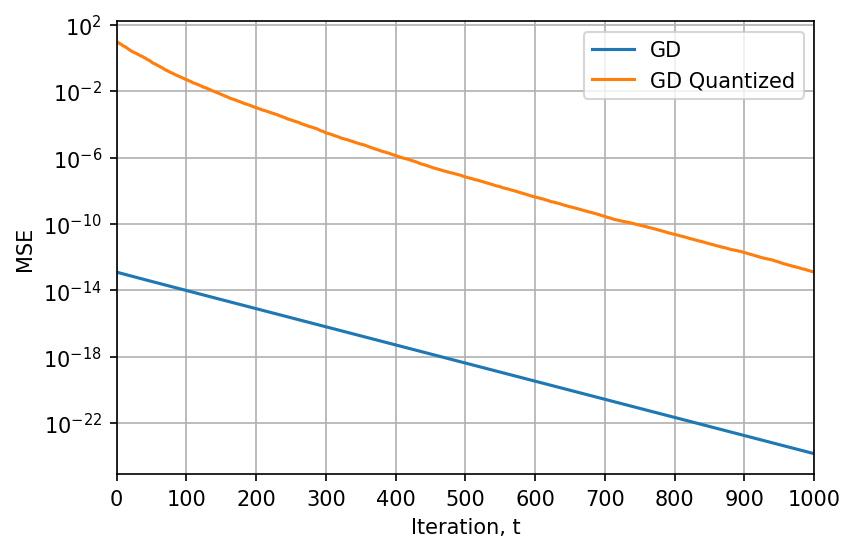

In [59]:
plt.figure(1, dpi = 150)
plt.xticks(np.linspace(0, T, 11))
# plt.ylim(10**-12, 10**2)
plt.xlim(0, T)
plt.grid(True, which = 'both', ls='-')
plt.semilogy(range(T), mse, label = 'GD')
plt.semilogy(range(T), mse_qnt, label = 'GD Quantized')

plt.xlabel('Iteration, t')
plt.ylabel('MSE')
plt.legend()

plt.show()